# DATASET


In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.6]


In [2]:
display_key = 'image'

ds = tfds.load("mimic_play", split="train", data_dir="gs://gresearch/robotics")
iterator = iter(ds)

2025-02-14 18:16:30.800476: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [4]:
# Print dataset structure in a more readable format
print("Dataset Structure:")
print("├── episode_metadata")
print("│   └── file_path: string")
print("└── steps")
print("    ├── action: float32[7]")
print("    ├── discount: float32")
print("    ├── is_first: bool")
print("    ├── is_last: bool") 
print("    ├── is_terminal: bool")
print("    ├── language_embedding: float32[512]")
print("    ├── language_instruction: string")
print("    ├── observation")
print("    │   ├── image")
print("    │   │   ├── front_image_1: uint8[120,120,3]")
print("    │   │   └── front_image_2: uint8[120,120,3]")
print("    │   ├── state")
print("    │   │   ├── ee_pose: float32[7]")
print("    │   │   ├── gripper_position: float32")
print("    │   │   ├── joint_positions: float32[7]")
print("    │   │   └── joint_velocities: float32[7]")
print("    │   └── wrist_image")
print("    │       └── wrist_image: uint8[120,120,3]")
print("    └── reward: float32")

Dataset Structure:
├── episode_metadata
│   └── file_path: string
└── steps
    ├── action: float32[7]
    ├── discount: float32
    ├── is_first: bool
    ├── is_last: bool
    ├── is_terminal: bool
    ├── language_embedding: float32[512]
    ├── language_instruction: string
    ├── observation
    │   ├── image
    │   │   ├── front_image_1: uint8[120,120,3]
    │   │   └── front_image_2: uint8[120,120,3]
    │   ├── state
    │   │   ├── ee_pose: float32[7]
    │   │   ├── gripper_position: float32
    │   │   ├── joint_positions: float32[7]
    │   │   └── joint_velocities: float32[7]
    │   └── wrist_image
    │       └── wrist_image: uint8[120,120,3]
    └── reward: float32


In [3]:
images = []
for episode in ds.take(1):
  for i, step in enumerate(episode["steps"]):
    images.append(
      Image.fromarray(
        np.concatenate((
              step["observation"]["image"]["front_image_1"].numpy(),
              step["observation"]["image"]["front_image_2"].numpy(),
        ), axis=1)
      )
    )

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-01-28 18:00:02.240004: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-28 18:05:46.959239: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-28 18:12:07.691920: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE


In [5]:
episode = next(iterator)

iter_steps = iter(episode['steps'])
eef_states = [state['observation']['state']['ee_pose'] for state in iter_steps] # Joint states

iter_steps = iter(episode['steps'])
joint_states = [state['observation']['state']['joint_positions'] for state in iter_steps]

2025-01-28 18:17:26.599446: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# ENV


In [30]:
xml_path = '../mujoco_menagerie/franka_emika_panda/scene_mimic.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL


In [73]:
# Visualize environment with initial pose from trajectory
env.init_viewer(
    title='Tabletop',
    transparent=False,
    azimuth=133,
    distance=3.5,
    elevation=-42.4,
    lookat=(-0.06,0.07,0.31),
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7']

env.reset()
env.forward(q=joint_states[60], joint_names=joint_names)

while env.is_viewer_alive():
  if env.loop_every(tick_every=10):
    env.plot_T(
        T=env.get_T_body(body_name='link_base'),
        axis_len=0.5,print_xyz=False)
    env.plot_text(
        p=env.get_p_body(body_name='link_base')+np.array([0,0,0.5]),
        label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
    
    env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
    env.plot_contact_info(
        r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
    
    env.render()

env.close_viewer()

In [74]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,255],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7',] # Except fingers

# Don't Know Why.....
# q0 = np.array([0, -1, 0, 1, 6, 1.7, 0])

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = q_traj[60]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = np.append(qpos,xyzrpyg[6]), #np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),s
        ctrl_idxs   = [0,1,2,3,4,5,6,7])
        #joint_names = joint_names)
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link_base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link_base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


In [62]:
sliders = MultiSliderClass( # Slider for joint control
    n_slider      = 8,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7', 'Gripper'],
    slider_mins   = np.degrees(env.joint_ranges[:-6,0]).tolist() + [0], # Convert joint ranges from radians to degrees
    slider_maxs   = np.degrees(env.joint_ranges[:-6,1]).tolist() + [255],
    slider_vals   = [0, 0, 0, 0, 0, 0, 0, 0],
    resolutions   = [(max-min)/50 for min,max in zip(np.degrees(env.joint_ranges[:-6,0]).tolist() + [0], 
                                                    np.degrees(env.joint_ranges[:-6,1]).tolist() + [255])],
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7'] # Except fingers

q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    joint_values = sliders.get_slider_values()
    
    # Convert degrees to radians for joint angles
    qpos = np.radians(joint_values[:7])
    
    env.step( # dynamic update
        ctrl        = np.append(qpos, joint_values[7]), # Last value is gripper
        ctrl_idxs   = [0,1,2,3,4,5,6,7])
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link_base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link_base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec'%(env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


# Trajectory


### 1) genration


In [31]:
joint_names = ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6', 'joint7']
q0 = np.array(joint_states[0])
# q0 = np.zeros_like(joint_names, dtype=float)

q_traj = []

q_ik_init = q0.copy()
for ik_target in eef_states:

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = ik_target[:3],
        R_trgt             = quat2r(np.concatenate([ik_target[4:], ik_target[3:4]])),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

### 2) Comparing


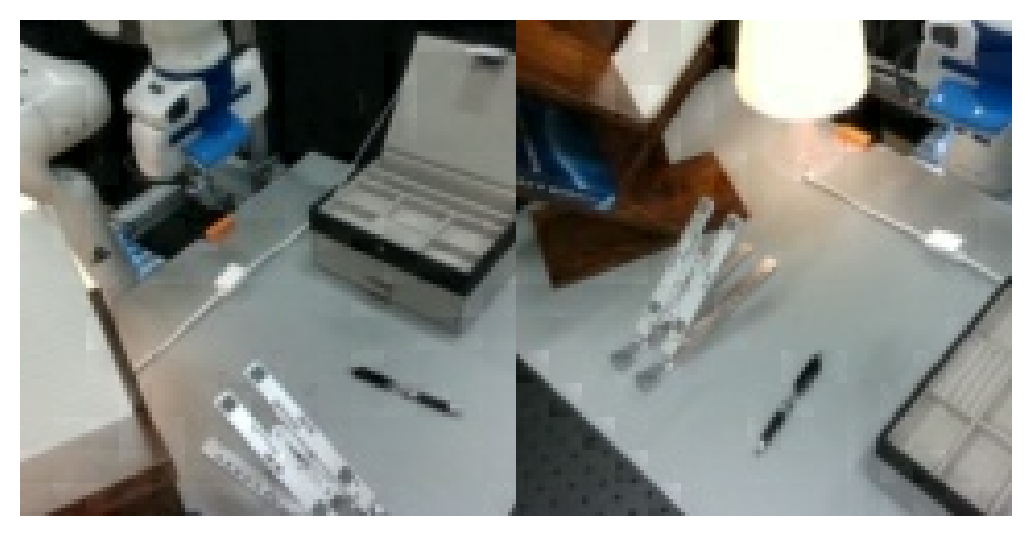

Done.


In [24]:
# G -> B -> R

idx = 400
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7',] # Except fingers

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos,
        joint_names = joint_names)
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

# Trajectory Reappearance


In [33]:
joint_names = ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6', 'joint7']
q0 = np.array(joint_states[0])

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

# append two gripper states to qpos
# gripper = gripper_states[0]
# qpos = np.append(qpos, [gripper, gripper])

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=1):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]
        # gripper = gripper_states[idx]
        # qpos = np.append(qpos, [gripper, gripper])

        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


: 

In [29]:
joint_names = ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6', 'joint7']
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = joint_states[0]
idx = 0

real_eef = [np.zeros(7) for _ in range(len(joint_states))]

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)
    real_eef[idx] = env.get_p_body(body_name='tcp_link')
    # Render 
    if env.loop_every(HZ=1):
        if idx == 10:
            print(env.get_p_body(body_name='tcp_link'))

        if idx < len(joint_states)-1:
            idx += 1
        else: idx = 0

        qpos = joint_states[idx]  # Use first 7 joints from joint_states

        env.plot_T(
            T=env.get_T_body(body_name='link0'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link0')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

# [ 0.46062913 -0.0419206   0.58133918] (calculated by joint_states) -> [0.46408984 -0.04164245  0.38942292] (EEF)
# [ 0.46334388 -0.04195479  0.57160527] (calculated by joint_states) -> [0.4666901  -0.04140665  0.37968513] (EEF)

[ 0.398775   -0.00789503  0.37744911]
[ 0.398775   -0.00789503  0.37744911]
Done.


# Reverse Engineering


In [25]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = eef_states[idx][3:]
target = quat2r(target)

base = env.get_R_body(body_name='link7')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
# print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))


'''
[-5.27306031e-17  9.32701387e-17  1.57079633e+00]
[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]
[ 0.72716463  0.04836099  0.05041956 -0.68289874]
[ 0.70710678  0.          0.         -0.70710678]


[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]
'''

[ 0.00391093 -0.92425175  0.3817606   0.00149838]


'\n[-5.27306031e-17  9.32701387e-17  1.57079633e+00]\n[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]\n[ 0.72716463  0.04836099  0.05041956 -0.68289874]\n[ 0.70710678  0.          0.         -0.70710678]\n\n\n[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]\n'